[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/agent-memory.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239417-lesson-7-agent-with-memory)

# Agents

## Review

Run analyst agents

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph langgraph-prebuilt

In [3]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [5]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

This follows what we did previously.

In [6]:
from langchain_openai import ChatOpenAI

In [7]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
llm = ChatOpenAI(model="gpt-4o")


In [8]:
# state classes init
class AnalystManagerState(MessagesState):
    ticker: str = ""
    fundamental_analysis: str
    technical_analysis: str

In [ ]:
fundamental_analyst_sys_msg = SystemMessage(content="""You are a professional equity research analyst specializing in fundamental analysis.

    You have access to comprehensive financial data including:
    - 2 years of annual financial statements (income, balance sheet, cash flow)
    - 2 quarters of recent quarterly data (income, balance sheet, cash flow, earnings)
    - Financial ratios, key metrics, and enterprise values (both annual and quarterly)
    - Company profile (sector, industry, market cap, description)

    Your role is to analyze this comprehensive dataset to assess the stock's investment potential.

    Your output must:
    1. Provide a concise **summary** of the company's financial state based on both annual trends and recent quarterly performance.
    2. Assess **growth potential** (strong / moderate / weak) with justification from both historical and recent data.
    3. Assess **risk factors** (low / moderate / high) with justification from financial ratios and trends.
    4. Evaluate whether the stock appears **undervalued, fairly valued, or overvalued** 
       relative to its sector and key financial metrics.
    5. Mention notable strengths and weaknesses, highlighting any significant changes in recent quarters.
    6. Output a **structured JSON object** with:
       - "growth_score": {"score": 0-10, "justification": "brief explanation"},
       - "risk_score": {"score": 0-10, "justification": "brief explanation"},
       - "summary" (3–5 sentence human-readable summary),
       - "notes" (key metrics and evidence in bullet points),
       - "strengths_and_weaknesses": {"strengths": ["list of strengths"], "weaknesses": ["list of weaknesses"]}.

    Keep your tone factual, objective, and professional. 
    Base your analysis strictly on the comprehensive financial data provided.""")

# Node
def fundamental_analyst(state: AnalystManagerState) -> AnalystManagerState:
    """Analyze fundamental data and populate the fundamental_analysis state"""

    ticker = state["ticker"]
    # Get fundamental data
    fundamental_data = """{
  "growth_score": {
    "score": 8,
    "justification": "Tesla has shown strong revenue growth over years with increased investments in R&D and production capacity. Recent quarterly reports indicate continued revenue growth."
  },
  "risk_score": {
    "score": 6,
    "justification": "Tesla has a high beta and relatively high debt-equity ratio, indicating moderate risk due to market volatility and financial leverage."
  },
  "summary": "Tesla, Inc. continues to showcase strong growth potential with significant increases in revenue and strategic investments. Although profitability dipped in 2024, likely due to rising costs and market conditions, the company's substantial reinvestment in R&D and capacity suggests a strategic focus on long-term growth. Tesla's stock appears overvalued in terms of its high P/E and P/S ratios, though its leadership in electric vehicles and energy sectors may justify this premium for some investors.",
  "notes": [
    "Revenue grew to $97.69 billion in 2024, a slight increase from $96.77 billion in 2023.",
    "Net income decreased significantly from $14.99 billion in 2023 to $7.13 billion in 2024 due to increased expenses and lower profit margins.",
    "Current liquidity ratios improved with a current ratio of 2.02 (2024) vs. 1.72 (2023).",
    "Enterprise value increased to $1.295 trillion in 2024 from $0.782 trillion in 2023.",
    "P/E ratio soared to 181.98 in 2024, indicating overvaluation risk compared to peers."
  ],
  "strengths_and_weaknesses": {
    "strengths": [
      "Leading market position in EV and energy storage sectors.",
      "Consistent revenue growth with strategic reinvestment in R&D.",
      "Strong liquidity position with increasing cash reserves."
    ],
    "weaknesses": [
      "High valuation ratios indicate potential overvaluation risk.",
      "Fluctuating profitability with recent decline in net income.",
      "High market volatility as reflected by a beta of 2.065."
    ]
  }
}
"""
    
    # Create analysis request
    analysis_prompt = f"""
    Analyze the following fundamental data for {ticker} and provide your assessment:
    
    {fundamental_data}
    
    Please provide your analysis in the exact JSON format specified in the system message.
    """
    
    # Get analysis from LLM
    messages = [fundamental_analyst_sys_msg, HumanMessage(content=analysis_prompt)]
    response = llm.invoke(messages)

    return {
      "fundamental_analysis": response.content
    }
    

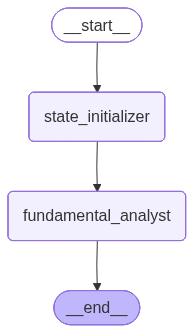

In [ ]:
from langgraph.graph import END, START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display



def state_initializer(state: MessagesState) -> AnalystManagerState:
    """Extract ticker from the input message string"""
    
    # System message for ticker extraction
    ticker_extraction_msg = SystemMessage(content="""You are a ticker extraction specialist. 
    Your job is to extract the stock ticker symbol from user messages.
    
    Rules:
    - Look for 2-5 letter uppercase stock symbols (e.g., AAPL, TSLA, GOOGL, MSFT)
    - The ticker might be in phrases like "analyze AAPL", "TSLA stock", "look at GOOGL"
    - Only return the ticker symbol itself, nothing else
    - If you can't find a clear ticker, return "UNKNOWN"
    
    Examples:
    - "analyze AAPL" → AAPL
    - "I want to know about Tesla stock TSLA" → TSLA  
    - "Can you analyze GOOGL for me?" → GOOGL
    - "What about MSFT?" → MSFT
    """)

    response = llm.invoke([ticker_extraction_msg] + state["messages"]);

    return {
            "ticker": response.content
           }
    
    

# Graph
builder = StateGraph(AnalystManagerState, input_schema=MessagesState)

builder.add_node("state_initializer", state_initializer)
builder.add_node("fundamental_analyst", fundamental_analyst)
builder.add_edge(START, "state_initializer")
builder.add_edge("state_initializer", "fundamental_analyst")
builder.add_edge("fundamental_analyst", END)

graph = builder.compile()

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

## Memory

Let's run our agent, as before.

In [16]:
messages = [HumanMessage(content="Look at NVDA")]
messages = graph.invoke({"messages": messages})

# for m in messages['messages']:
#     m.pretty_print()

messages

{'messages': [HumanMessage(content='Look at NVDA', additional_kwargs={}, response_metadata={}, id='1b3fa72c-18d2-4a15-a3b2-c173a004c772'),
  AIMessage(content='NVDA', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 2, 'prompt_tokens': 184, 'total_tokens': 186, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CH7daU3JmbCH9IVuCH4LfixNtZsYH', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--0faf0d47-e154-4c45-a7e7-07017799d86e-0', usage_metadata={'input_tokens': 184, 'output_tokens': 2, 'total_tokens': 186, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
  AIMessage(content='```json\n{\n  "growth_score": {\n   

In [17]:
messages['ticker']


'A'

In [10]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================

It seems like you're requesting a multiplication operation, but I don't have the number you want to multiply by 2. Could you please provide the number?


We don't retain memory of 7 from our initial chat!

This is because [state is transient](https://github.com/langchain-ai/langgraph/discussions/352#discussioncomment-9291220) to a single graph execution.

Of course, this limits our ability to have multi-turn conversations with interruptions. 

We can use [persistence](https://langchain-ai.github.io/langgraph/how-tos/persistence/) to address this! 

LangGraph can use a checkpointer to automatically save the graph state after each step.

This built-in persistence layer gives us memory, allowing LangGraph to pick up from the last state update. 

One of the easiest checkpointers to use is the `MemorySaver`, an in-memory key-value store for Graph state.

All we need to do is simply compile the graph with a checkpointer, and our graph has memory!

In [11]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
react_graph_memory = builder.compile(checkpointer=memory)

When we use memory, we need to specify a `thread_id`.

This `thread_id` will store our collection of graph states.

Here is a cartoon:

* The checkpointer write the state at every step of the graph
* These checkpoints are saved in a thread 
* We can access that thread in the future using the `thread_id`

![state.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e0e9f526b41a4ed9e2d28b_agent-memory2.png)


In [12]:
# Specify a thread
config = {"configurable": {"thread_id": "1"}}

# Specify an input
messages = [HumanMessage(content="Add 3 and 4.")]

# Run
messages = react_graph_memory.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_UkSLfYoWxOxAg5A0tbJ6VuYR)
 Call ID: call_UkSLfYoWxOxAg5A0tbJ6VuYR
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


If we pass the same `thread_id`, then we can proceed from from the previously logged state checkpoint! 

In this case, the above conversation is captured in the thread.

The `HumanMessage` we pass (`"Multiply that by 2."`) is appended to the above conversation.

So, the model now know that `that` refers to the `The sum of 3 and 4 is 7.`.

In [13]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_UkSLfYoWxOxAg5A0tbJ6VuYR)
 Call ID: call_UkSLfYoWxOxAg5A0tbJ6VuYR
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.
================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_6x9lE2gLEoEvutS2bLfizcBT)
 Call ID: call_6x9lE2gLEoEvutS2bLfizcBT
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================

The result of multipl

## LangGraph Studio


**⚠️ DISCLAIMER**

Since the filming of these videos, we've updated Studio so that it can be run locally and opened in your browser. This is now the preferred way to run Studio (rather than using the Desktop App as shown in the video). See documentation [here](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server) on the local development server and [here](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server). To start the local development server, run the following command in your terminal in the `module-1/studio/` directory in this module:

```
langgraph dev
```